In [24]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn import datasets
from sklearn.model_selection import train_test_split

from collections import Counter

import numpy as np

%matplotlib inline

<b>Домашнее задание:</b> <br>
1) реализовать аналогичного изученному дерева решений, использующего энтропию Шенонна в качестве критерия информативности и сравнить точность(accuracy, balanced_accuracy) достигаемую на используемых синтетических данных с точностью разобранной на уроке реализации <br>
2) реализовать ограничение глубины дерева при построении. Построить на этом же датасете дерево, у которого максимальная глубина листа равна 2.

<b>Домашнее задание повышенной трудности(необязательно):</b> реализовать на листьях дерева рассчёт доли/вероятности принадлежности к классу. Рассчитать вероятности предсказываемые для объектов тестовой выборки, вычислить с их помощью AUC-ROC и AUC-PR характеристики

In [25]:
class Node:

    def __init__(self, index, t, true_branch, false_branch):
        # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.index = index
        self.t = t  # значение порога
        # поддерево, удовлетворяющее условию в узле
        self.true_branch = true_branch
        # поддерево, не удовлетворяющее условию в узле
        self.false_branch = false_branch


class Leaf:

    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        self.predict_proba = self.proba()

    def predict(self):
        # подсчет количества объектов разных классов
        classes = Counter(self.labels)

        #  найдем класс, количество объектов которого будет максимальным
        #  в этом листе и вернем его
        return max(classes, key=classes.get)

    def proba(self):
        # вернем вероятность целевого класса вместо метки класса
        classes = Counter(self.labels)
        return classes[1] / len(self.labels)


class DecisionTree:
    def __init__(self, crit='gini', min_leaf=5, n_depth=None):
        self.crit = crit
        self.min_leaf = min_leaf
        self.n_depth = n_depth
        self._tree = None

    def _build_tree(self, data, labels, depth):
        quality, t, index = self._find_best_split(data, labels)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        # или достигнута максимальная глубина дерева
        if quality == 0 or (self.n_depth is not None) and (depth >= self.n_depth):
            return Leaf(data, labels)

        true_data, false_data, true_labels, false_labels = self._split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        # Инкрементируем текущую глубину дерева и передаем ее в рекурсию
        depth += 1
        true_branch = self._build_tree(true_data, true_labels, depth)
        false_branch = self._build_tree(false_data, false_labels, depth)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return Node(index, t, true_branch, false_branch)

    def _info_crit(self, labels):
        #  подсчет количества объектов разных классов
        classes = Counter(labels)

        #  расчет критерия Джини
        if self.crit == 'gini':
            impurity = 1
            impurity -= np.sum([(classes[_i] / len(labels)) ** 2 for _i in classes])
        #  расчет энтропии Шэннона
        elif self.crit == 'shannon':
            impurity = 0
            for obj in classes:
                p = classes[obj] / len(labels)
                impurity += -p * np.log2(p)
        else:
            raise ValueError('Wrong information criterion')

        return impurity

    def _quality(self, left_lbl, right_lbl, current_info):
        # доля выборки, ушедшая в левое поддерево
        p = float(left_lbl.shape[0]) / (left_lbl.shape[0] + right_lbl.shape[0])
        return current_info - p * self._info_crit(left_lbl) - (1 - p) * self._info_crit(right_lbl)

    @staticmethod
    def _split(data, labels, index, t):
        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)
        return data[left], data[right], labels[left], labels[right]

    def _find_best_split(self, data, labels):
        #  обозначим минимальное количество объектов в узле
        current_info = self._info_crit(labels)

        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            # будем проверять только уникальные значения признака,
            # исключая повторения
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_lbl, false_lbl = self._split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < self.min_leaf or len(false_data) < self.min_leaf:
                    continue

                current_quality = self._quality(true_lbl, false_lbl, current_info)

                #  выбираем порог, на котором получается максимальный
                #  прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index

    def _classify_object(self, obj, node, proba=False):
        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            if proba:
                answer = node.predict_proba
            else:
                answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self._classify_object(obj, node.true_branch, proba)
        else:
            return self._classify_object(obj, node.false_branch, proba)

    def fit(self, data, labels):
        self._tree = self._build_tree(data, labels, depth=0)

    def predict(self, data, proba=False):
        return np.array([self._classify_object(obj, self._tree, proba=proba) for obj in data])

    def _max_depth(self, node):
        if isinstance(node, Leaf):
            return 0
        ldepth = self._max_depth(node.true_branch)
        rdepth = self._max_depth(node.false_branch)
        return ldepth + 1 if ldepth > rdepth else rdepth + 1

    def _p_tree(self, node, level=0):
        if not isinstance(node, Leaf):
            self._p_tree(node.true_branch, level + 1)
            print(' ' * 5 * level + '-->', f'{node.t:.3f}')
            self._p_tree(node.false_branch, level + 1)

    def get_depth(self):
        return self._max_depth(self._tree)

    def print_tree(self):
        self._p_tree(self._tree)


In [26]:
def accuracy_metric(actual, predicted):
    return np.sum(actual == predicted) / len(actual)


def balanced_accuracy_metric(actual, predicted):
    true_predicted = (actual == predicted).astype(np.int8)
    sensitivity = np.sum(actual * true_predicted) / np.sum(actual == 1)
    specificity = np.sum((1 - actual) * true_predicted) / np.sum(actual == 0)
    return 0.5 * (sensitivity + specificity)


def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step),
                       np.arange(y_min, y_max, step))

In [32]:
cls_data, cls_labels = datasets.make_classification(n_samples=1000,
                                                    n_features=2,
                                                    n_informative=2,
                                                    n_classes=2,
                                                    n_redundant=0,
                                                    n_clusters_per_class=2,
                                                    random_state=142)

train_data, test_data, train_labels, test_labels = train_test_split(cls_data,
                                                                    cls_labels,
                                                                    test_size=0.3,
                                                                    random_state=1)

Построим дерево с помощью критерия Джини

In [33]:
# Построим дерево по обучающей выборке
my_tree = DecisionTree(crit='gini', min_leaf=3, n_depth=4)
my_tree.fit(train_data, train_labels)
# Получим ответы для обучающей выборки
train_answers = my_tree.predict(train_data)
# И получим ответы для тестовой выборки
test_answers = my_tree.predict(test_data)
# Точность на обучающей выборке
print(f'Train -> Accuracy: {accuracy_metric(train_labels, train_answers):.3f}, '
      f'Balanced accuracy: {balanced_accuracy_metric(train_labels, train_answers):.3f}')
print(f'Test --> Accuracy: {accuracy_metric(test_labels, test_answers):.3f}, '
      f'Balanced accuracy: {balanced_accuracy_metric(test_labels, test_answers):.3f}')
print(f'Глубина построенного дерева:{my_tree.get_depth()}\n')
my_tree.print_tree()

Train -> Accuracy: 0.977, Balanced accuracy: 0.977
Test --> Accuracy: 0.953, Balanced accuracy: 0.953
Глубина построенного дерева:4

               --> 0.067
          --> 2.065
     --> -0.768
               --> -1.011
          --> -0.634
               --> 1.597
--> -0.093
          --> 0.080
     --> -2.165
               --> 0.985
          --> 1.448
               --> 1.503


Сравним с энтропией Шэннона

In [35]:
my_tree = DecisionTree(crit='shannon', min_leaf=3, n_depth=4)
my_tree.fit(train_data, train_labels)
# Получим ответы для обучающей выборки
train_answers = my_tree.predict(train_data)
# И получим ответы для тестовой выборки
test_answers = my_tree.predict(test_data)
# Точность на обучающей выборке
print(f'Train -> Accuracy: {accuracy_metric(train_labels, train_answers):.3f}, '
      f'Balanced accuracy: {balanced_accuracy_metric(train_labels, train_answers):.3f}')
print(f'Test --> Accuracy: {accuracy_metric(test_labels, test_answers):.3f}, '
      f'Balanced accuracy: {balanced_accuracy_metric(test_labels, test_answers):.3f}')
print(f'Глубина построенного дерева:{my_tree.get_depth()}\n')

Train -> Accuracy: 0.974, Balanced accuracy: 0.974
Test --> Accuracy: 0.943, Balanced accuracy: 0.943
Глубина построенного дерева:4



Как видим, разница незначительная

Посмотрим, какую глубину дерева мы получим без ограничения в 4

In [37]:
my_tree = DecisionTree(crit='shannon', min_leaf=3, n_depth=None)
my_tree.fit(train_data, train_labels)
# Получим ответы для обучающей выборки
train_answers = my_tree.predict(train_data)
# И получим ответы для тестовой выборки
test_answers = my_tree.predict(test_data)
# Точность на обучающей выборке
print(f'Train -> Accuracy: {accuracy_metric(train_labels, train_answers):.3f}, '
      f'Balanced accuracy: {balanced_accuracy_metric(train_labels, train_answers):.3f}')
print(f'Test --> Accuracy: {accuracy_metric(test_labels, test_answers):.3f}, '
      f'Balanced accuracy: {balanced_accuracy_metric(test_labels, test_answers):.3f}')
print(f'Глубина построенного дерева:{my_tree.get_depth()}\n')
my_tree.print_tree()

Train -> Accuracy: 0.984, Balanced accuracy: 0.984
Test --> Accuracy: 0.947, Balanced accuracy: 0.947
Глубина построенного дерева:9

          --> 0.067
               --> 0.120
                                   --> -1.156
                                        --> -1.125
                              --> 0.550
                         --> 0.555
                    --> 2.065
     --> -0.768
                    --> -0.513
               --> -0.469
          --> -1.011
                    --> -0.634
                         --> 1.597
                              --> 1.772
               --> 1.887
                    --> -0.564
                         --> 2.962
--> -0.093
          --> 0.080
     --> -2.165
          --> 0.975
               --> 0.988
                    --> 1.381
                         --> 1.508


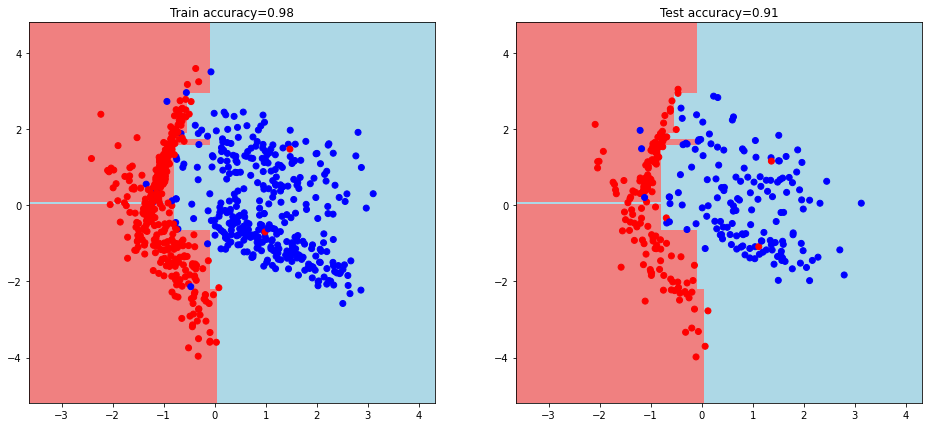

In [40]:
train_accuracy = accuracy_metric(train_labels, train_answers)
test_accuracy = accuracy_metric(test_labels, test_answers)
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])
plt.figure(figsize=(16, 7))

# график обучающей выборки
plt.subplot(1, 2, 1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(my_tree.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors, shading='auto')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels,
            cmap=colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1, 2, 2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors, shading='auto')
plt.scatter(test_data[:, 0], test_data[:, 1], c=test_labels, cmap=colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')
plt.show()

Посчитаем ROC-AUC

In [42]:
my_tree = DecisionTree(crit='shannon', min_leaf=5, n_depth=4)
my_tree.fit(train_data, train_labels)
test_proba = my_tree.predict(test_data, proba=True)

In [44]:
target = test_labels
order=np.argsort(test_proba)

target=target[order]
test_proba=test_proba[order]

In [45]:
for _x, t in zip(test_proba, target):
    print("Значение x:{0} класс {1}".format(_x, t))

Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:0.0 класс 0
Значение x:

In [46]:
bins_pos=target
bins_neg=1-target
num_pos, num_neg=np.sum(bins_pos), np.sum(bins_neg)
print(f'{num_pos} объектов положительного класса, {num_neg} объектов негативного класса')

149 объектов положительного класса, 151 объектов негативного класса


In [60]:
TPR=np.concatenate([[0], np.cumsum(bins_neg)/num_neg])
FPR=np.concatenate([[0], np.cumsum(bins_pos)/num_pos])

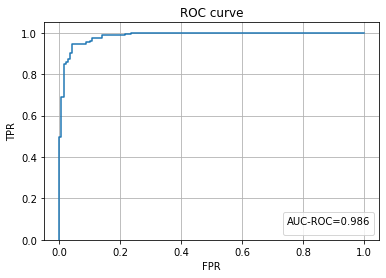

In [62]:
AUC_ROC = np.sum((FPR[1:]-FPR[:-1])*(TPR[1:]+TPR[:-1])/2)

plt.title('ROC curve')
plt.ylim(0, 1.05)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.legend(' ', title=f'AUC-ROC={AUC_ROC:.3f}', loc='lower right')
plt.plot(FPR, TPR);

и PR-AUC

In [73]:
precision=np.cumsum(bins_neg)/(np.cumsum(bins_neg)+np.cumsum(bins_pos))
recall = TPR

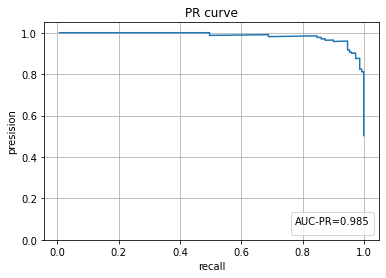

In [76]:
AUC_PR = np.sum(precision*(recall[1:]-recall[:-1]))

plt.title('PR curve')
plt.ylim(0, 1.05)
plt.xlabel('recall')
plt.ylabel('presision')
plt.grid()
plt.legend(' ', title=f'AUC-PR={AUC_PR:.3f}', loc='lower right')
plt.plot(recall[1:], precision);